# Analyzing the data

Import Shapely and Geopandas.

In [1]:
import requests
import pandas as pd 
from scrapy import Selector
from scrapy.http import HtmlResponse
import matplotlib.pyplot as plt
import numpy
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

I want to read the csv into a list of lists, just as the original updated_list.

In [2]:
import csv 
  
with open('Data/battle.csv', 'r') as read_obj: 

    csv_reader = csv.reader(read_obj) 

    updated_list = list(csv_reader) 

## Questions 1: Where do all the battles take places? Which place experience the most battles?

The longitudes and latitudes are in formats such as *50°27′49″N*. I need to convert them to decimals.

In [3]:
def conversion(old):
    directions = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    
    # Getting rid of special characters
    new = old.replace('°',' ').replace('′',' ').replace('″',' ')
    
    # Split the numbers
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    
    # Using the conversion algorithm
    try:
        result = (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * directions[new_dir]
    except ValueError:
        return None
    
    return result

Converting all longitudes and latitudes from the updated list of battles:

In [4]:
list_of_longitude = []
list_of_latitude = []

for item in updated_list:
    current_latitude = item[2]
    current_longtitude = item[3]
    try:
        list_of_latitude.append(conversion(current_latitude))
        list_of_longitude.append(conversion(current_longtitude))
    except KeyError:
        continue

Creating a csv of longitudes and latitudes.

In [5]:
longi_lati = []
title_row = ['longitude', 'latitude']
longi_lati.append(title_row)

i = 0
for i in range(len(list_of_longitude)):
    a = []
    a.append(list_of_longitude[i])
    a.append(list_of_latitude[i])
    longi_lati.append(a)

Plotting the data

In [6]:
df = pd.DataFrame(longi_lati)
df.to_csv('Data/all_locations.csv', index=False, header = None)

/var/folders/kf/qtx0lhgn07s5bcwbgq3727tm0000gn/T/ipykernel_43621/934525163.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

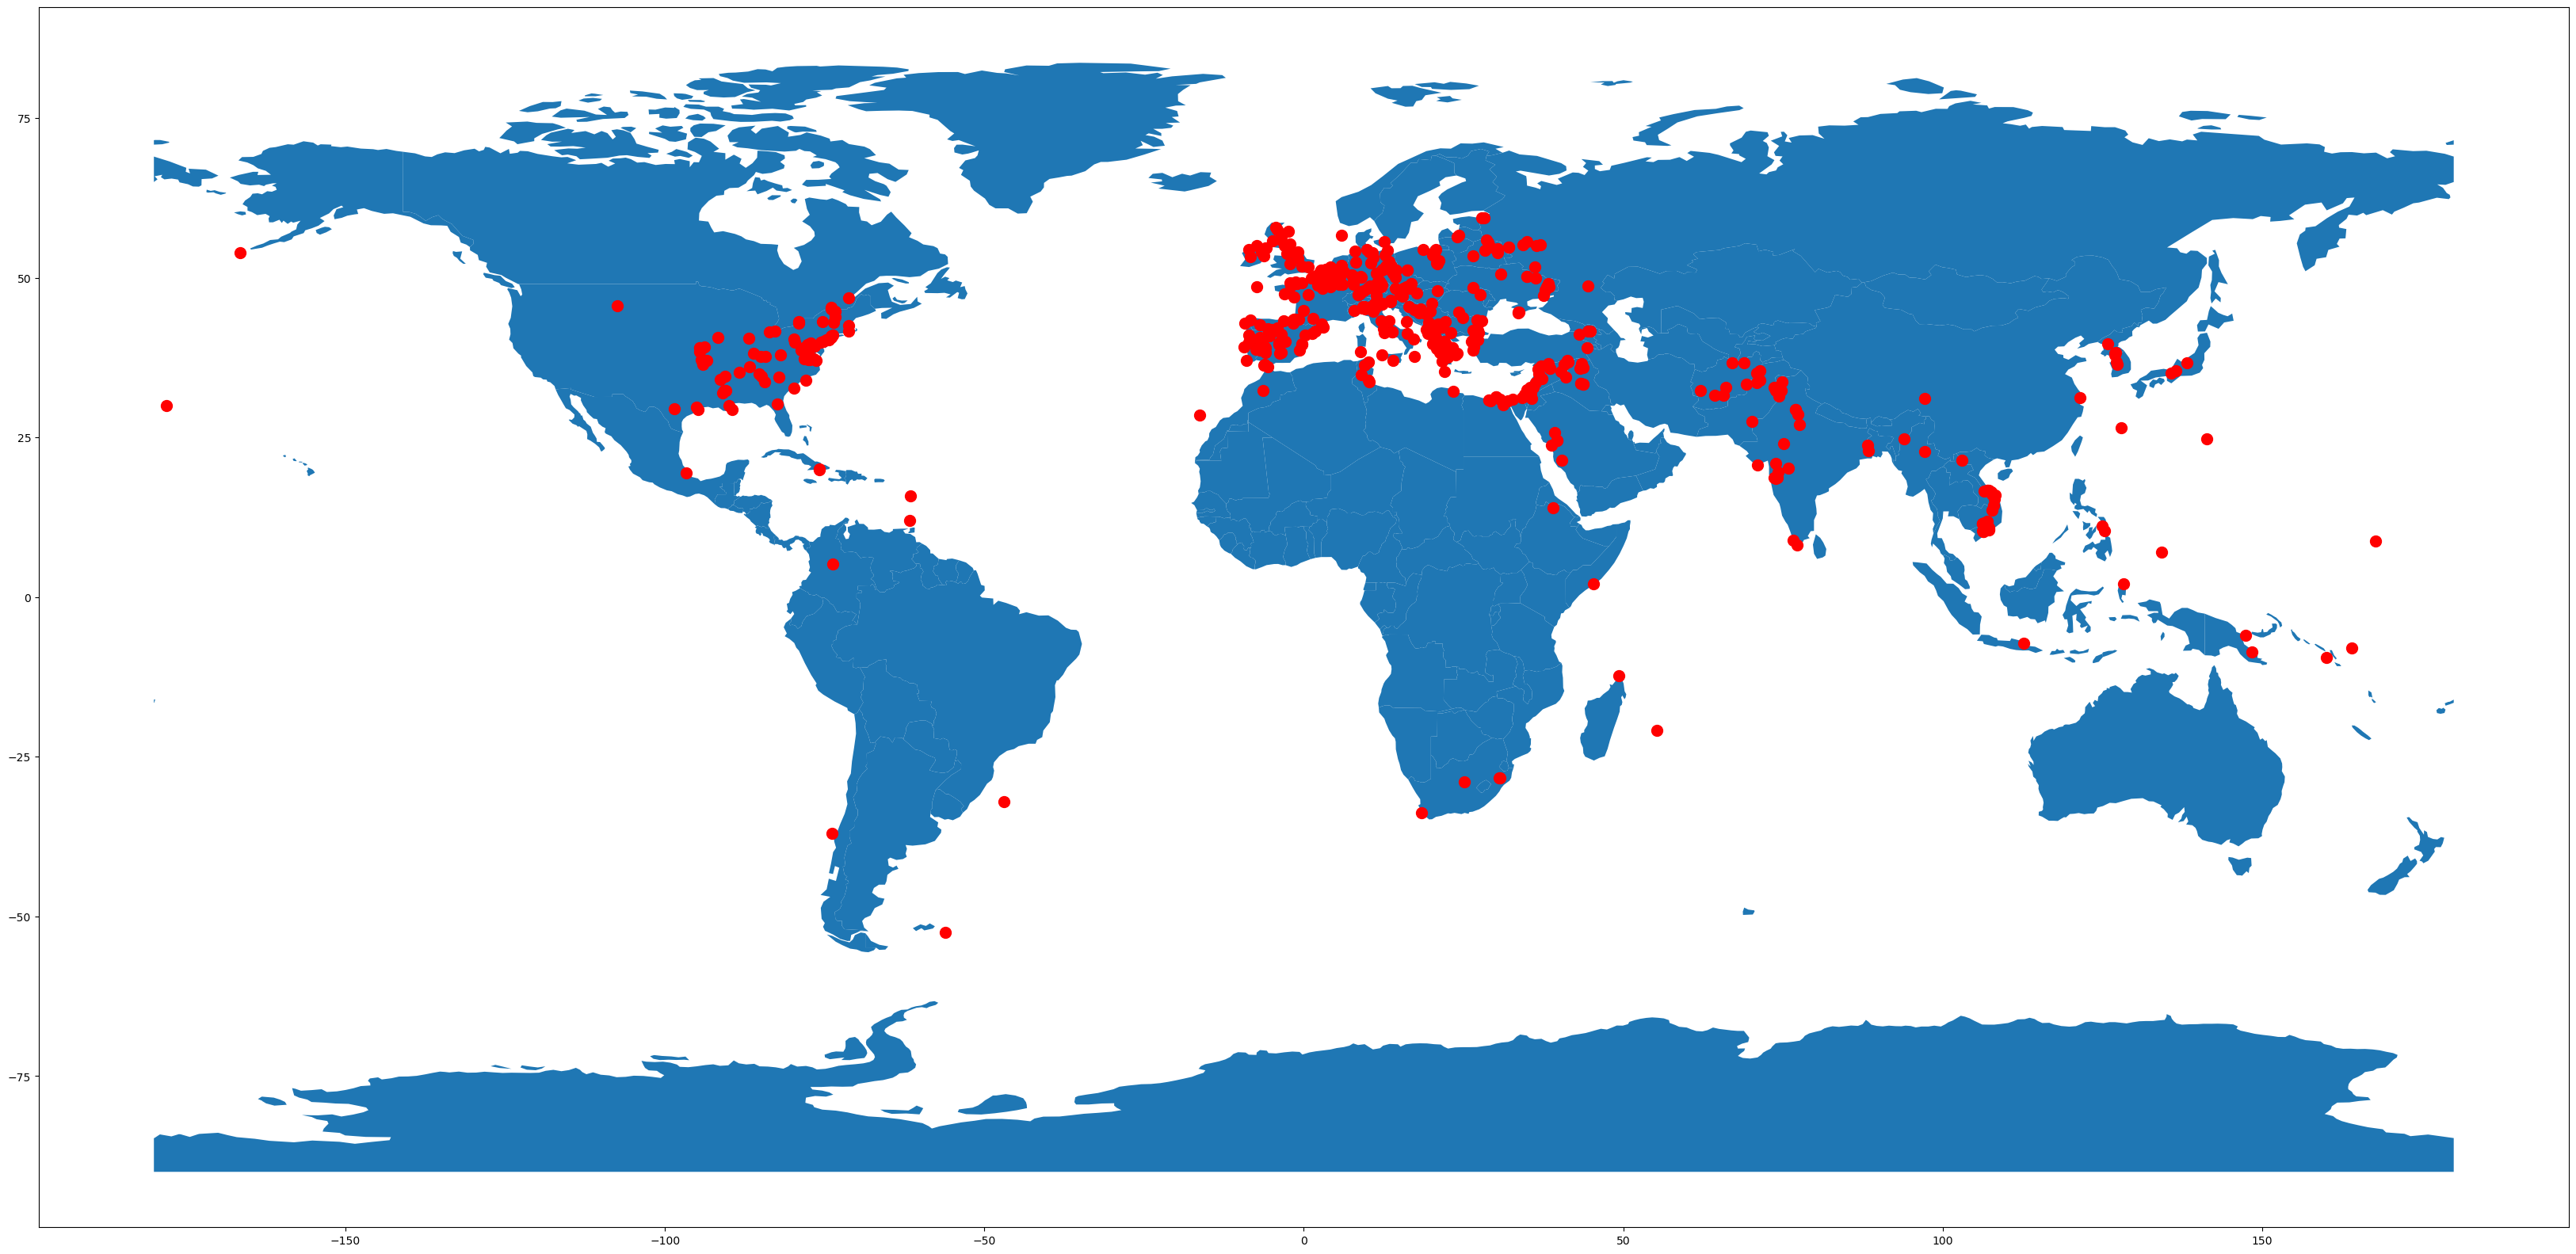

In [7]:
df = pd.read_csv("Data/all_locations.csv", delimiter=',', skiprows=0, low_memory=False)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(50, 20)), marker='o', color='red', markersize=100)

#### Conclution

Most battles (recorded on Wikipedia) take place in Europe and the east coast of the United States. China should have experienced a lot of battles, but not a lot are recorded on Wikipedia probably due to the language barrier.

## Questions 2: When do most battles recorded on Wikipedia take place?

In [8]:
list_of_dates = [x[1] for x in updated_list if x != ''] # Sometimes the mysterious '' messes things up. I remove it here.

Put the dates into groups of 100 years:

In [9]:
def find_date(dict_of_dates, item):

    for i in range (40): # Looping through all catagories of 100 years
        i = i - 20 # Minus 20 here to get -20 ~ 20
        lower_bound = 100 * i
        upper_bound = 100 * (i + 1)

        try:
            if lower_bound < item < upper_bound:
                if lower_bound in dict_of_dates:
                    dict_of_dates[lower_bound] += 1
                else:
                    dict_of_dates[lower_bound] = 1
        except TypeError:
            continue

        i = i + 20
        i += 1

    return(dict_of_dates)    

In [10]:
dict_of_dates = {-2000: 0, -1900: 0, -1800: 0, -1700: 0, 
                     -1600: 0, -1500: 0, -1400: 0, -1300: 0, 
                     -1200: 0, -1100: 0, -1000: 0, -900: 0, 
                     -800: 0, -700: 0, -600: 0, -500: 0,
                     -400: 0, -300: 0, -200: 0, -100: 0, 0: 0,
                     100: 0, 200: 0, 300: 0, 400: 0,
                     500: 0, 600: 0, 700: 0, 800: 0,
                     900: 0, 1000: 0, 1100: 0, 1200: 0,
                     1300: 0, 1400: 0, 1500: 0, 1600: 0,
                     1700: 0, 1800: 0, 1900: 0, 2000: 0,
                     }

for item in list_of_dates:
    if item == '': 
        continue
    else:
        try:
            item = float(item)
            dict_of_dates = find_date(dict_of_dates, item)
        except ValueError:
            continue

Putting keys and values into lists:

In [11]:
x = [x for x in dict_of_dates]
y = [dict_of_dates[x] for x in dict_of_dates]

Plotting the data:

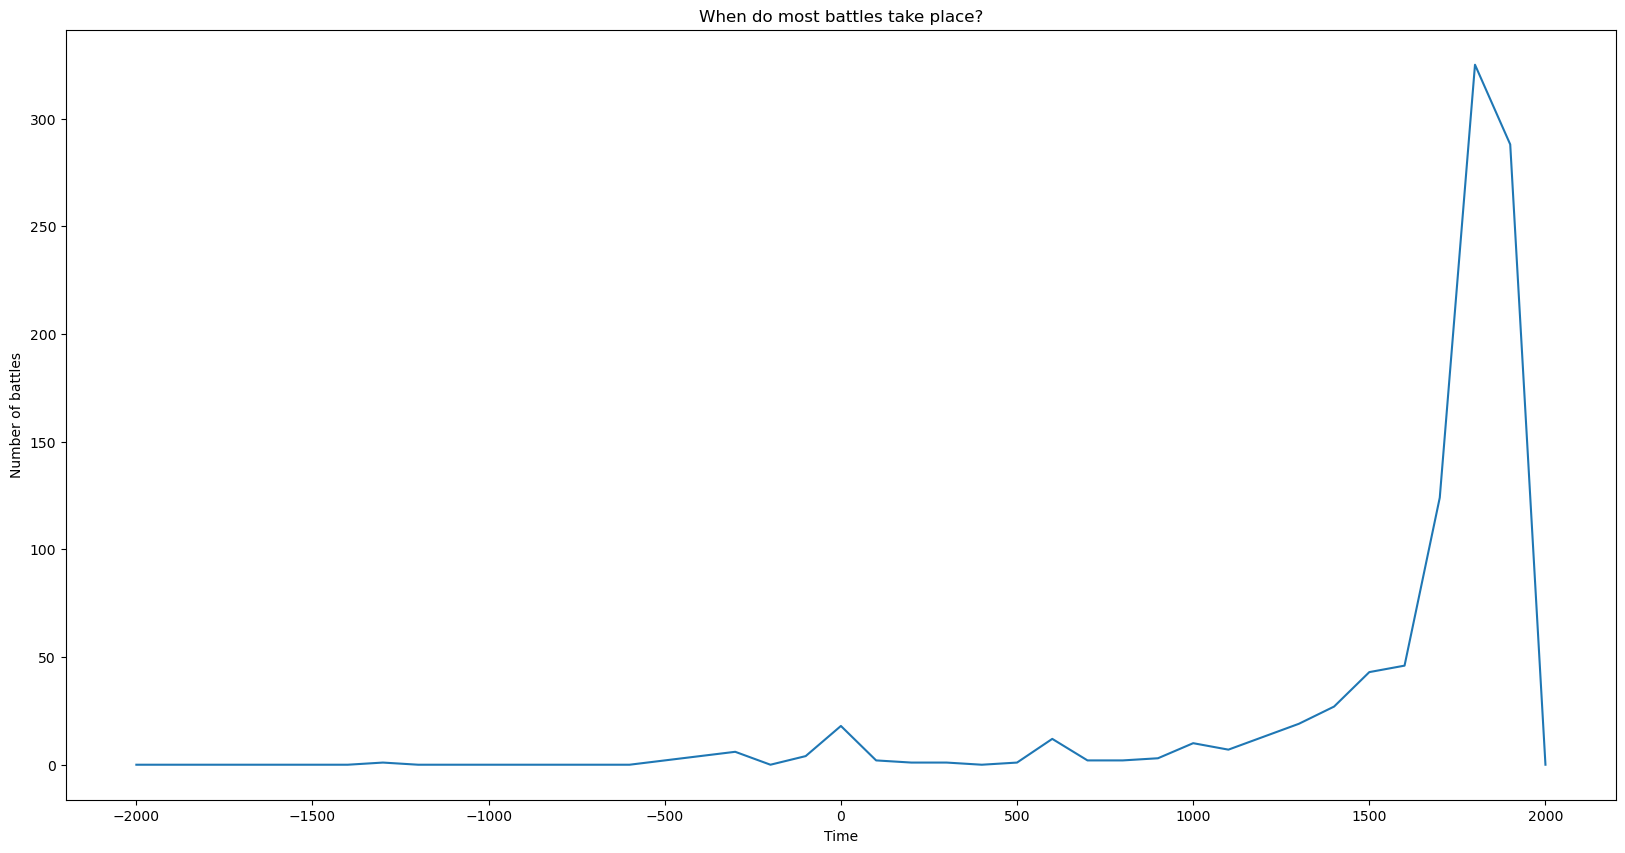

In [12]:
plt.figure(figsize=(20,10))
plt.title('When do most battles take place?')
plt.xlabel('Time')
plt.ylabel('Number of battles')
plt.plot(x,y)
plt.show()

#### Conclusion

Most battles recorded on Wikipedia take place between 1500 and 2000, very few are before 500 BC.

## Question 3: Who fought the most battles?

In [13]:
def count_belligerents(input_list):
    
    dict_of_belligerents = {}
    for item in input_list:
        a = item[4]
        b = item[5]
        if a != '':
            if a in dict_of_belligerents:
                dict_of_belligerents[a] += 1
            else:
                dict_of_belligerents[a] = 1

        if b != '':
            if b in dict_of_belligerents:
                dict_of_belligerents[b] += 1
            else:
                dict_of_belligerents[b] = 1

    # Sort the dictionary by values
    temporary_dict = sorted(dict_of_belligerents.items(), key=lambda x:x[1], reverse=True)
    sorted_dict_of_belligerents = dict(temporary_dict)
    
    # I dont want the plot to contain too much data. I want to create a threshold. 
    # Only belligerents that appear amount of times above the threshold will appear on the plot. 
    # I decide that the threshold should be the number of times the 8th highest value in the dict_of_belligerents.
    i = 0
    for key in sorted_dict_of_belligerents:
        i += 1
        if i == 12:
            threshold = sorted_dict_of_belligerents[key]
    
    # Putting the selected belligerents into a reduced list.
    reduced_list_of_belligerents = [[key, sorted_dict_of_belligerents[key]] for key in sorted_dict_of_belligerents if sorted_dict_of_belligerents[key] > threshold]
    
    # Plotting the data
    country = [x[0] for x in reduced_list_of_belligerents]
    count = [x[1] for x in reduced_list_of_belligerents]
    
    plt.figure(figsize=(30,10))
    plt.bar(range(len(reduced_list_of_belligerents)), count, width=0.5, linewidth=0.5, tick_label = country)
    plt.title('Who fought the most battles?')
    plt.xlabel('Countries')
    plt.ylabel('Times Appeared')
    plt.show()
    
    return plt

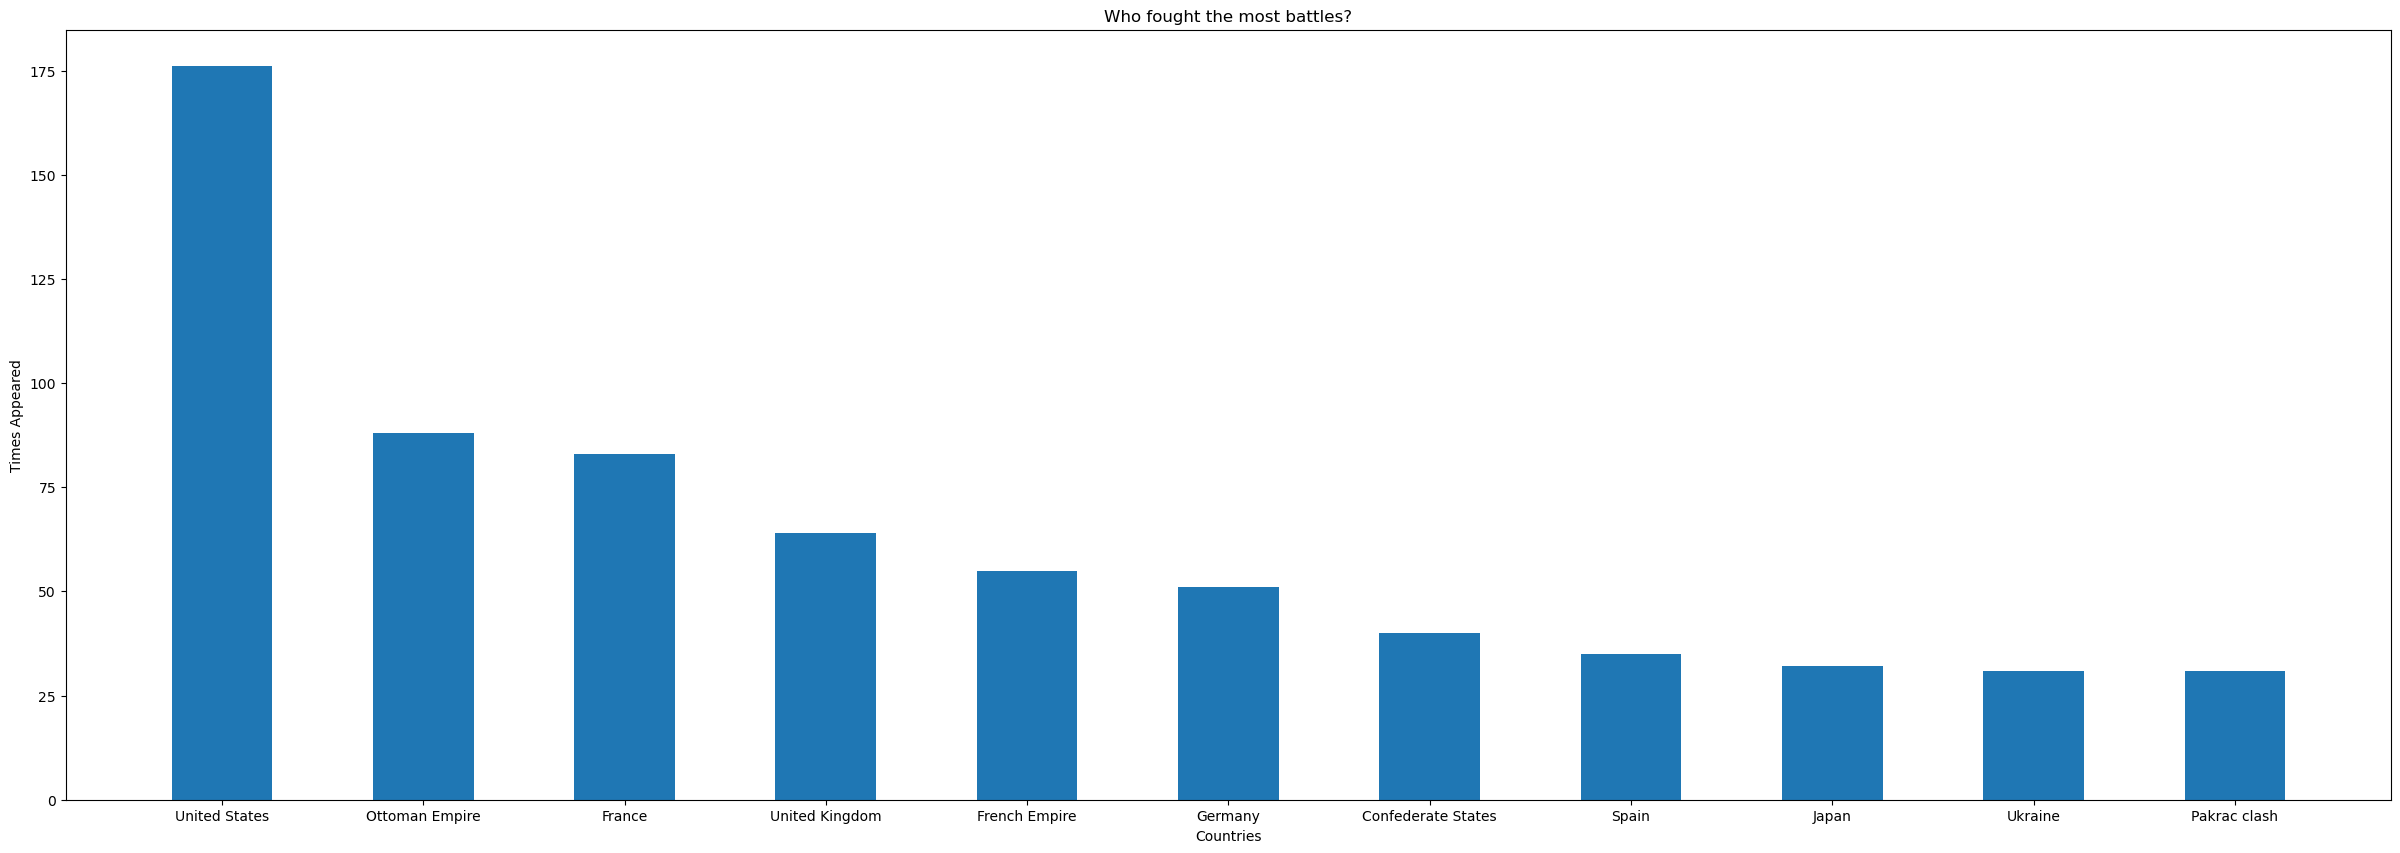

<module 'matplotlib.pyplot' from '/Users/wyt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [14]:
count_belligerents(updated_list)

#### Conclusion

United States, France, and the Ottoman Empire fought the most battles throughout the entire history. United Kingdom, Germany, Russia, Spain and Japan also fought a lot of battles.

## Question 4: Where do most battles take place during ancient history, post-classical history, and modern history?

### Ancient history

In [15]:
ancient_battles = []
post_classical_battles = []
modern_battles = []

ancient_battles = [x for x in updated_list if x[1] != None and x[1] != '' and float(x[1]) <= 500]
post_classical_battles = [x for x in updated_list if x[1] != None and x[1] != '' and 500 < float(x[1]) <= 1500]
modern_battles = [x for x in updated_list if x[1] != None and x[1] != '' and float(x[1]) > 1500]

In [16]:
def plot_map(input_list, name):
    list_of_longitude = []
    list_of_latitude = []
    for item in input_list:
        current_latitude = item[2]
        current_longtitude = item[3]
        try:
            list_of_latitude.append(conversion(current_latitude))
            list_of_longitude.append(conversion(current_longtitude))
        except KeyError:
            continue
            
    longi_lati = []
    title_row = ['longitude', 'latitude']
    longi_lati.append(title_row)

    i = 0
    for i in range(len(list_of_longitude)):
        a = []
        a.append(list_of_longitude[i])
        a.append(list_of_latitude[i])
        longi_lati.append(a)
        
    df = pd.DataFrame(longi_lati)
    df.to_csv('Data/' + name + '.csv', index=False, header = None)

    df = pd.read_csv('Data/' + name + '.csv', delimiter=',', skiprows=0, low_memory=False)

    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(50, 20)), marker='o', color='red', markersize=100)
    
    return(gdf.plot)

**Note**: you might wonder why I didn't use the 'plot_data' function earlier when I plot all battles. I have tried this, but for some reason it just doesn't work. When I use the `plot_data(updated_list)`, and run it for a first time, it only plots out two data points. But if I make no changes to the code and simply run it again, it will function properly and plot out all battles. I am using Jupyter Notebook and Anaconda. Maybe it is because the amount of data is too large, or other python bugs.

#### Ancient History

/var/folders/kf/qtx0lhgn07s5bcwbgq3727tm0000gn/T/ipykernel_43621/195509617.py:31: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


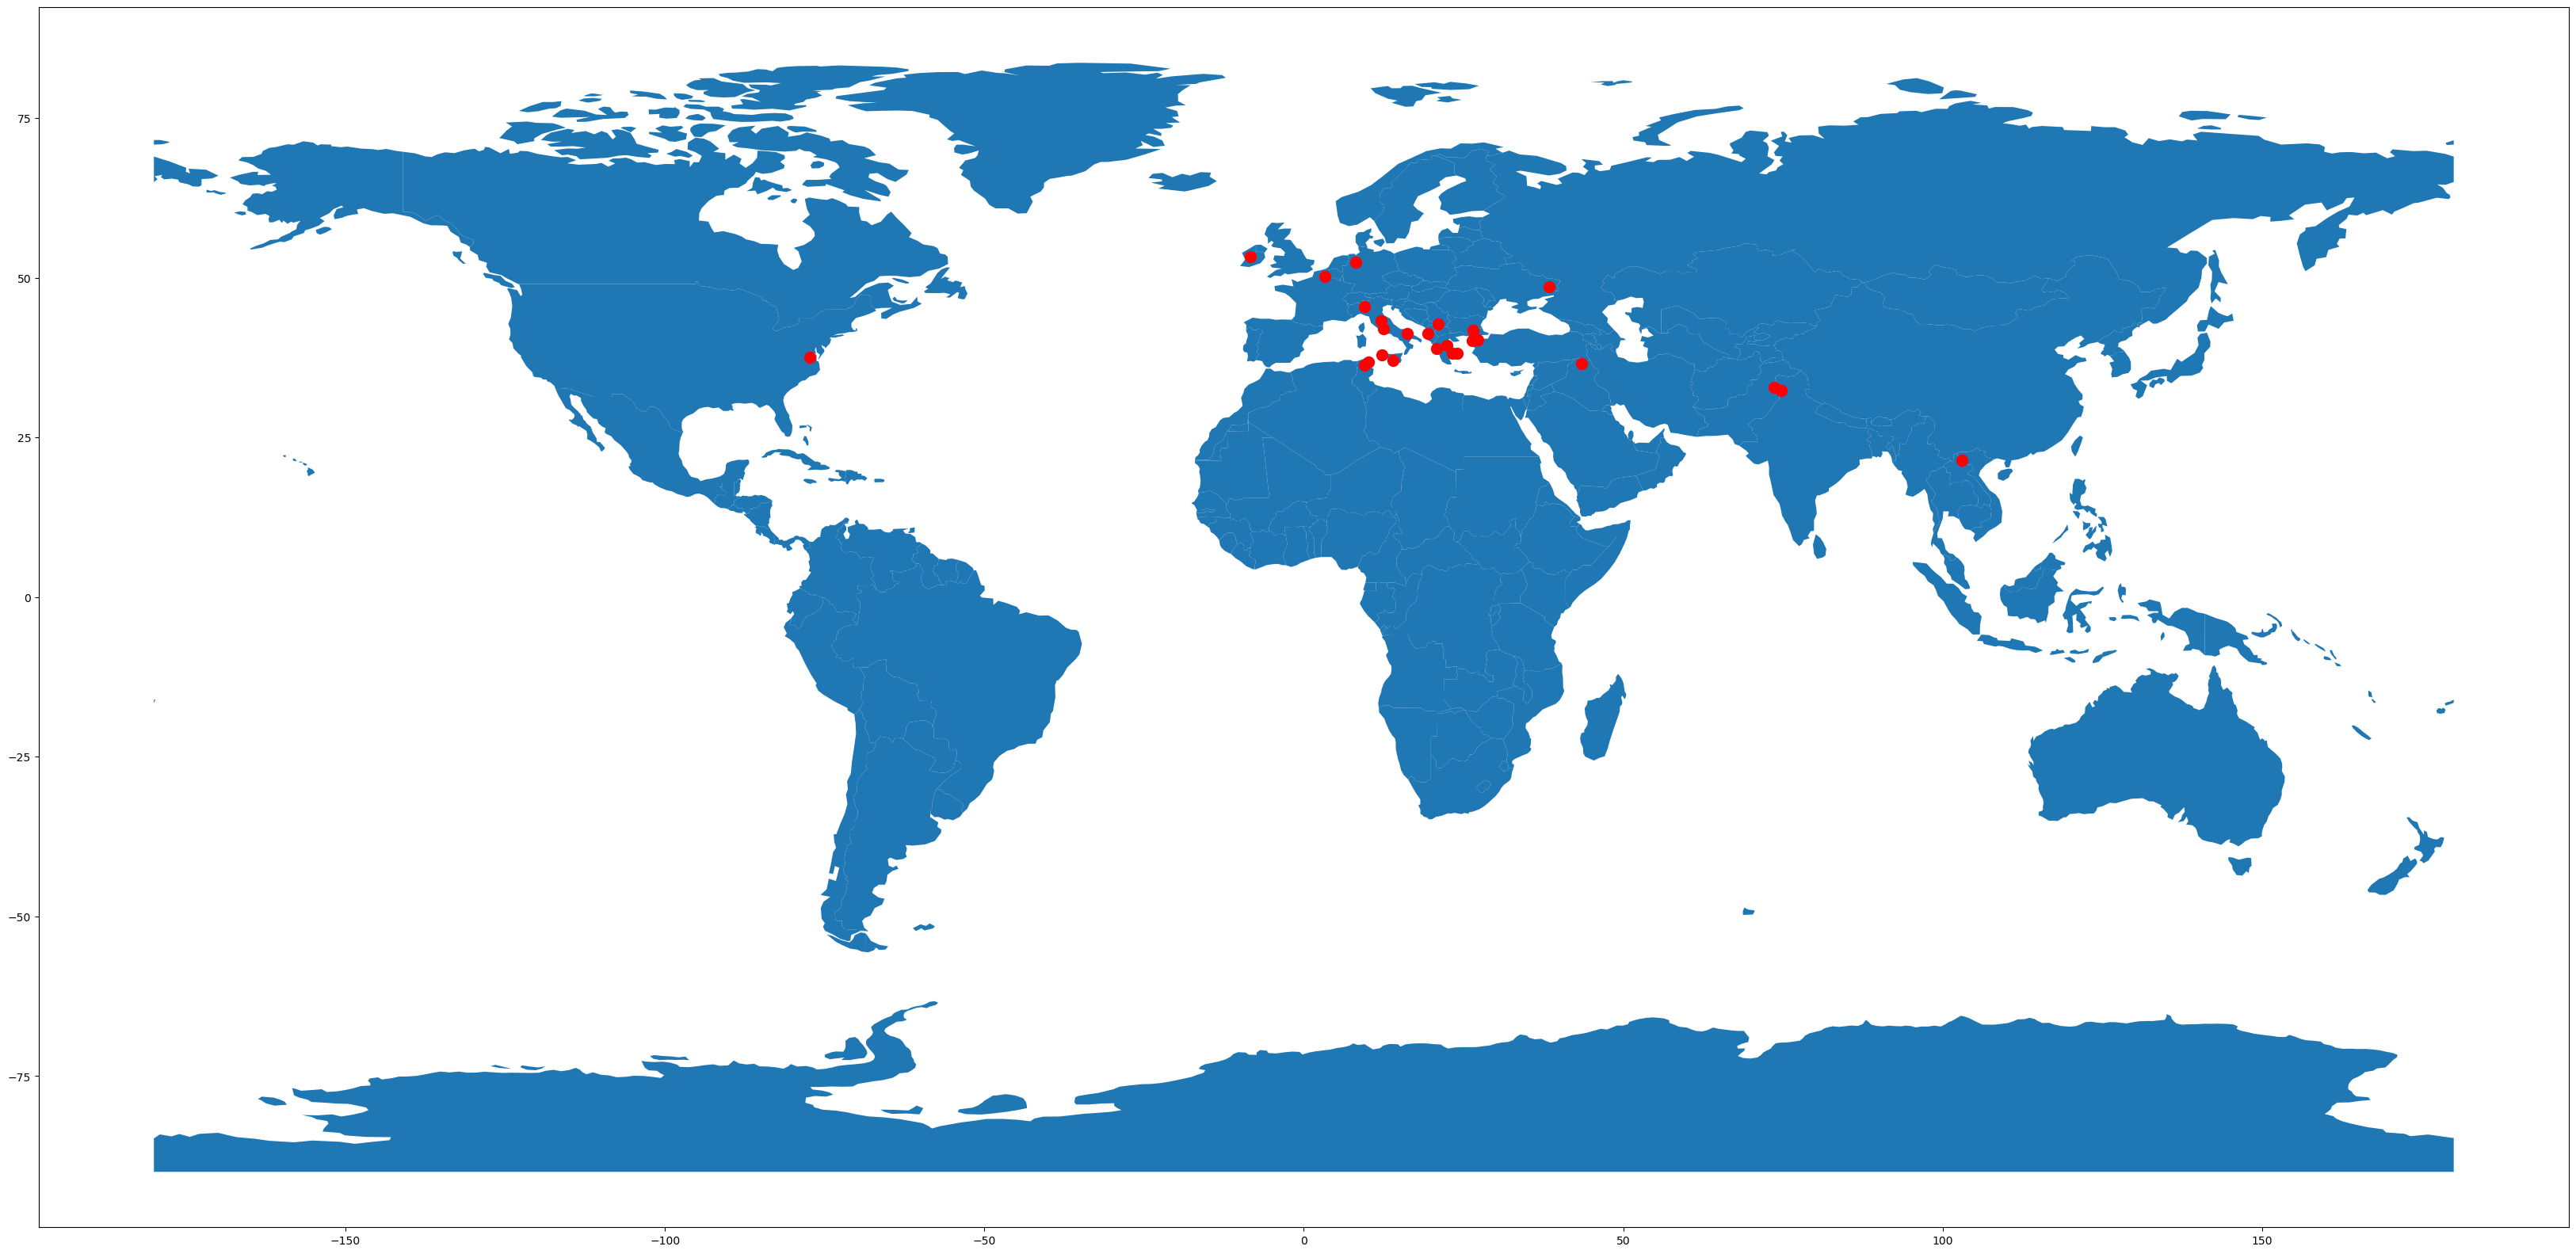

In [17]:
plot_map(ancient_battles, 'ancient_locations')

#### Post Classical History

/var/folders/kf/qtx0lhgn07s5bcwbgq3727tm0000gn/T/ipykernel_43621/195509617.py:31: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


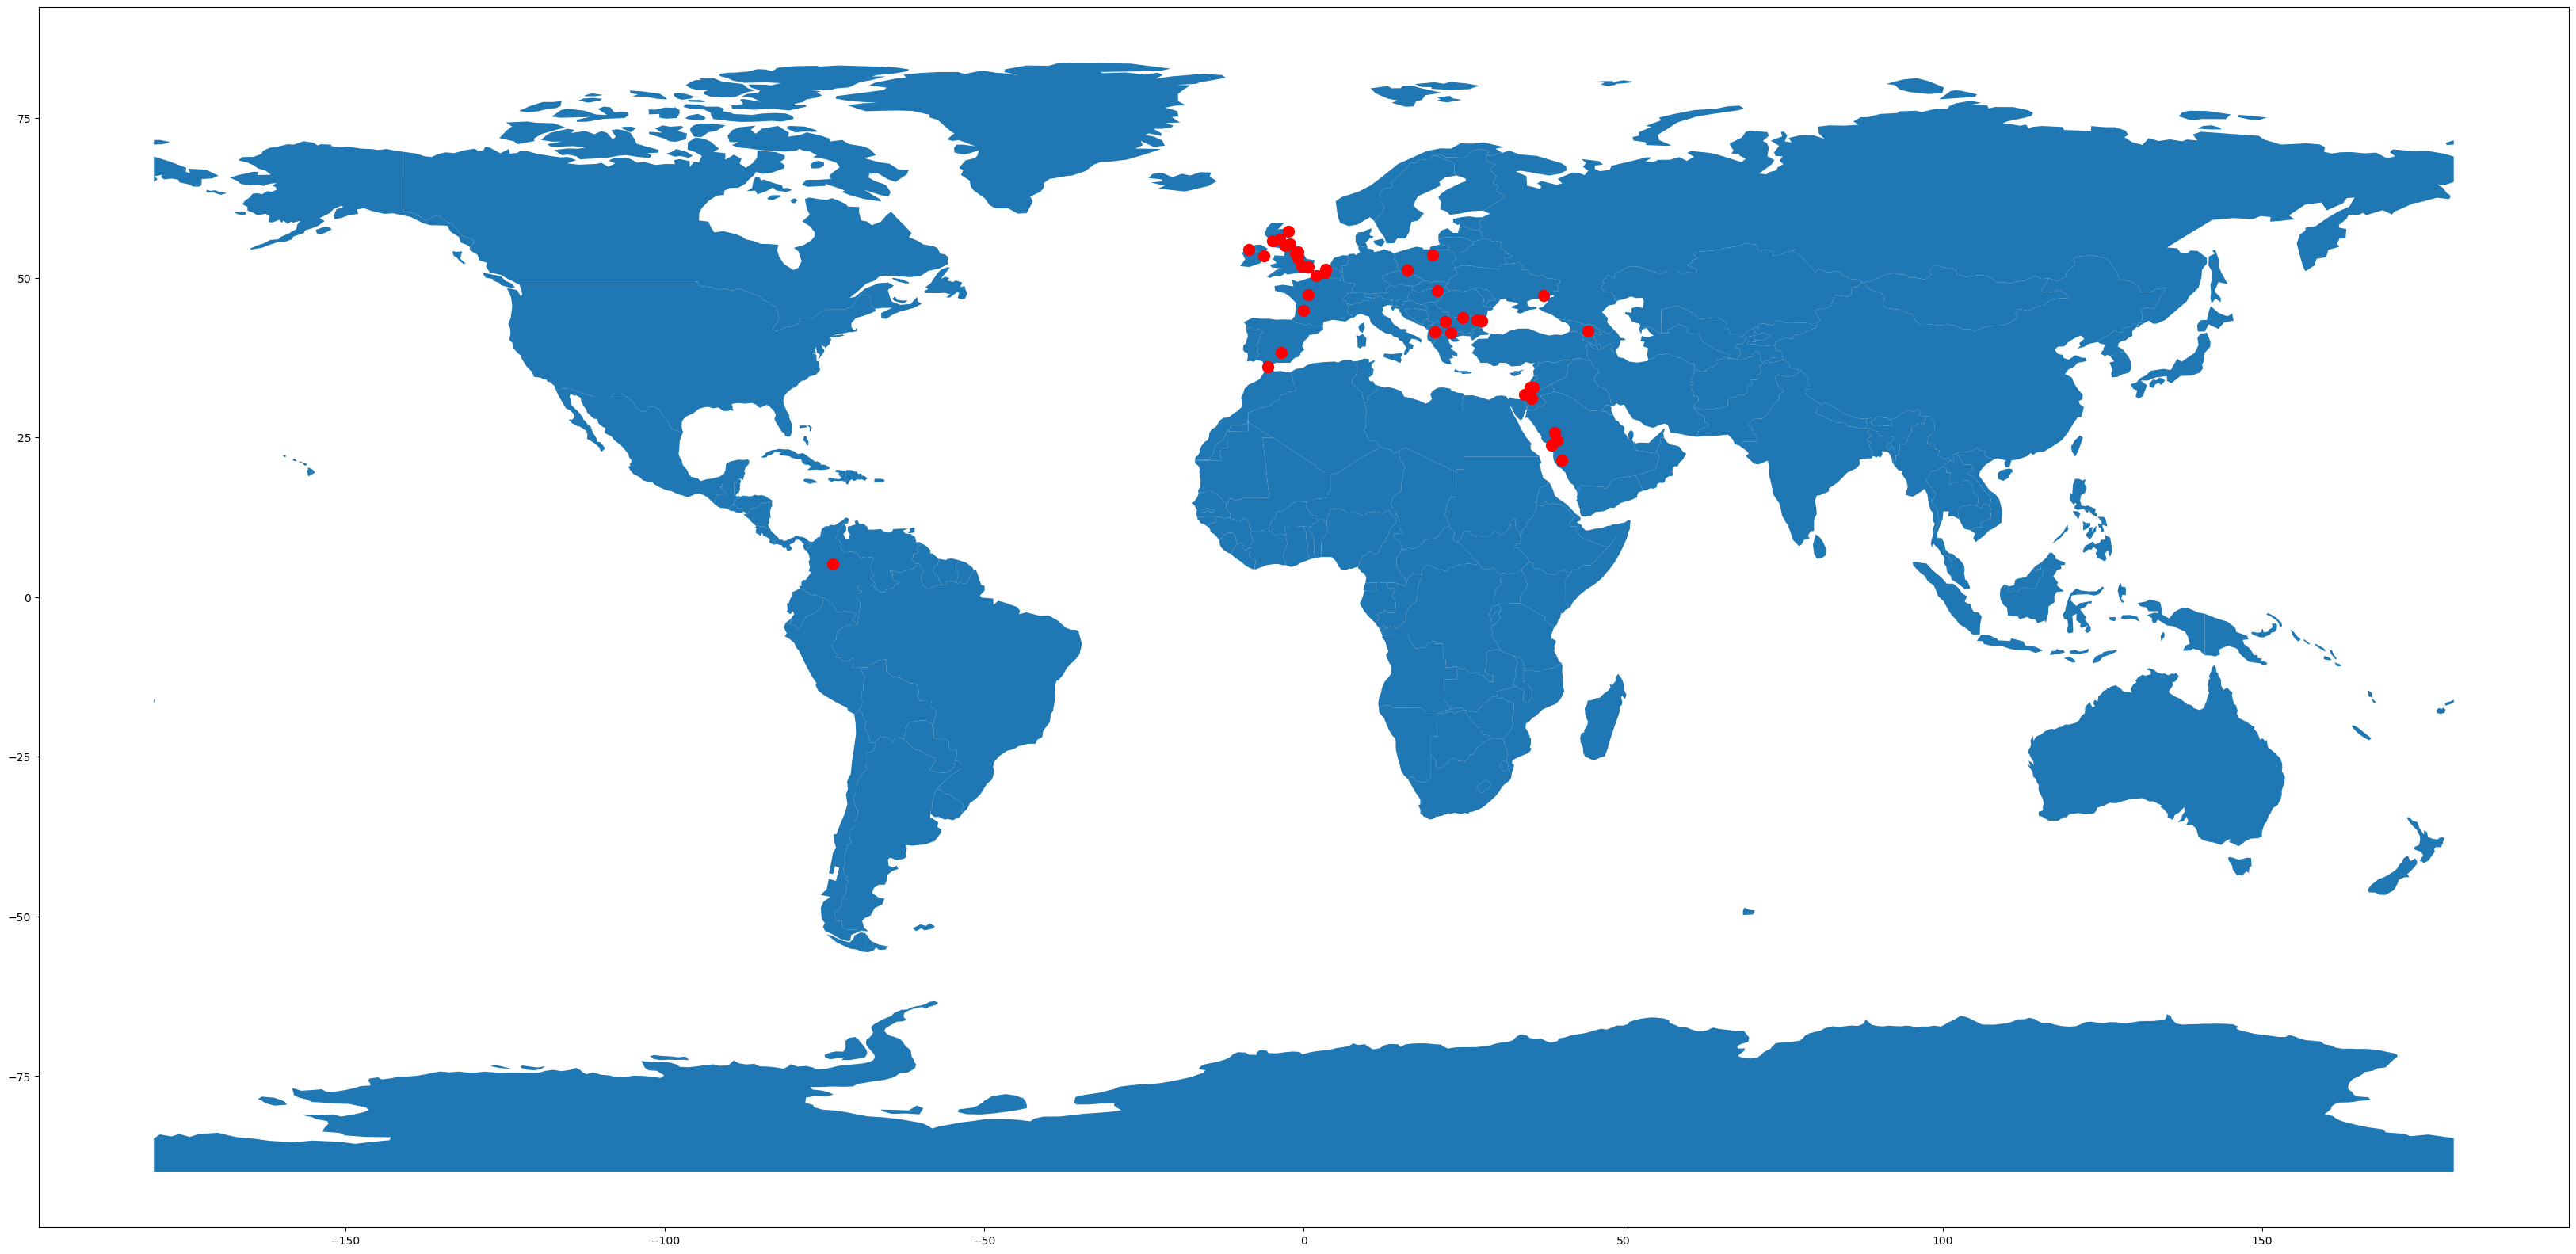

In [18]:
plot_map(post_classical_battles, 'post_classical_locations')

#### Modern History

/var/folders/kf/qtx0lhgn07s5bcwbgq3727tm0000gn/T/ipykernel_43621/195509617.py:31: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


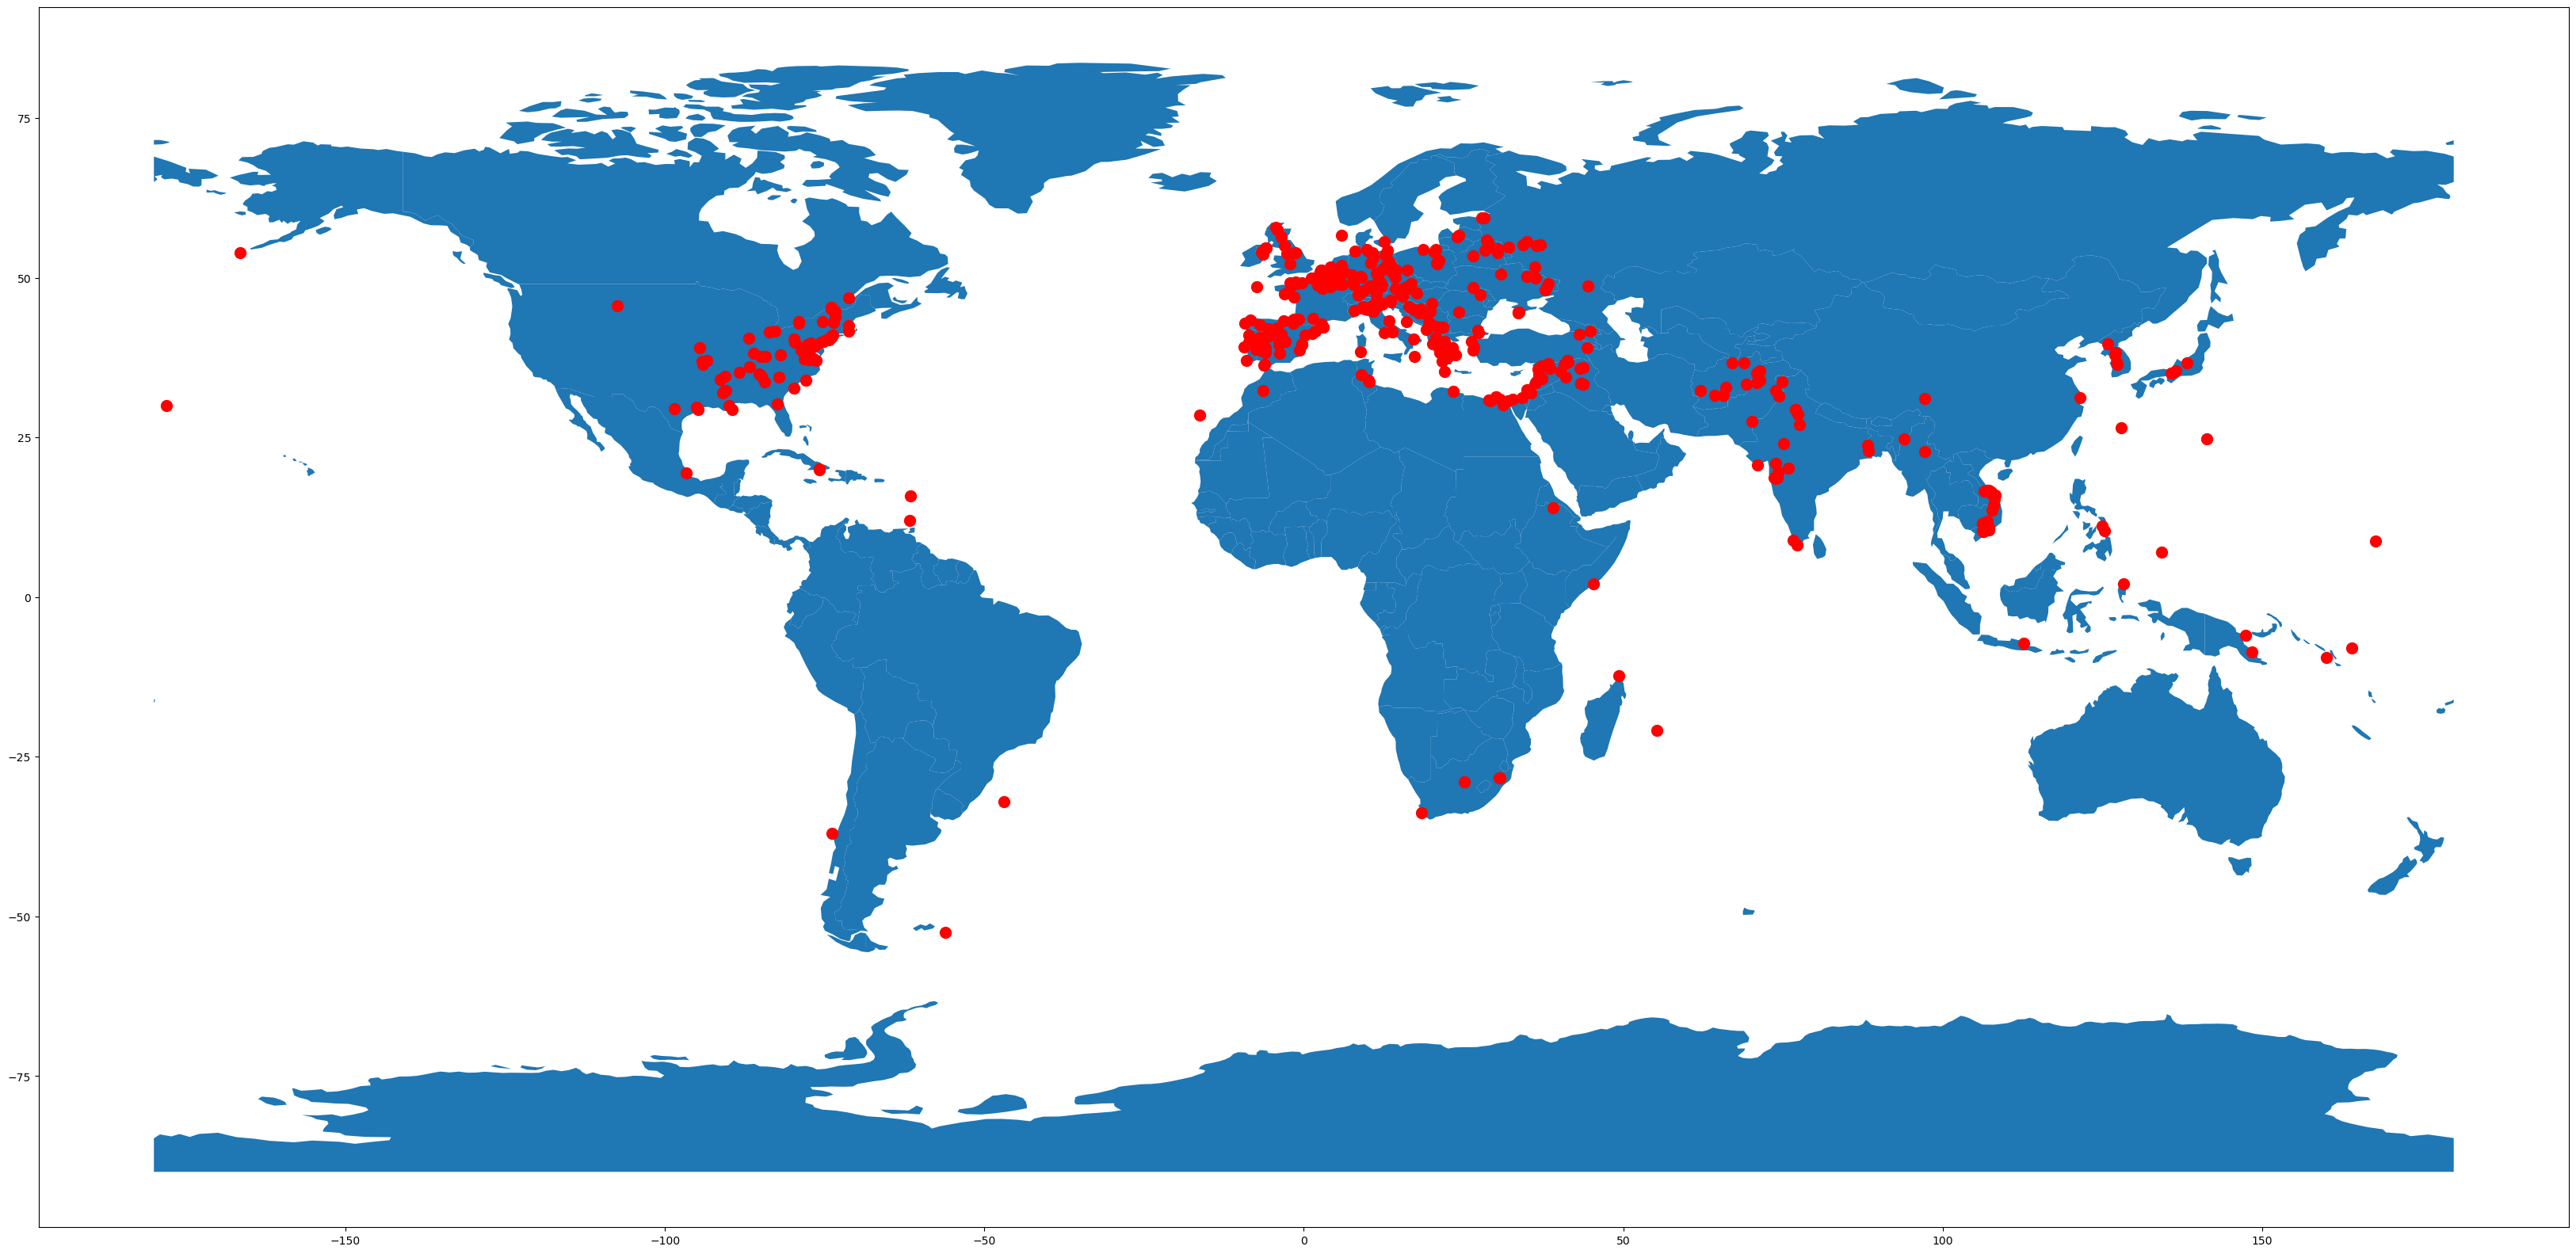

In [19]:
plot_map(modern_battles, 'modern_locations')

#### Conclusion

Most battles in ancient history took place in Europe, and some in China. One 1 took place in America. Only 1 battle was recorded in Britain, and none are recorded in South America and Sub-Saharan Africa.

This pattern generally holds for post-classical history, but with Britain fighting a lot more battles.

In modern history, Europe still fights lots of battles. Only in modern history that battles start to take place around the world (or battles around the world start to be recorded on Wikipedia). The United States fought a lot, and South America and Sub-Saharan Africa started to fight some battles.

Also, there were almost no documented naval battles before the modern era.

## Question 5: Whose fought the most battle in ancient history, post-classical history, and modern history?

#### Ancient History

#### Post Classical History

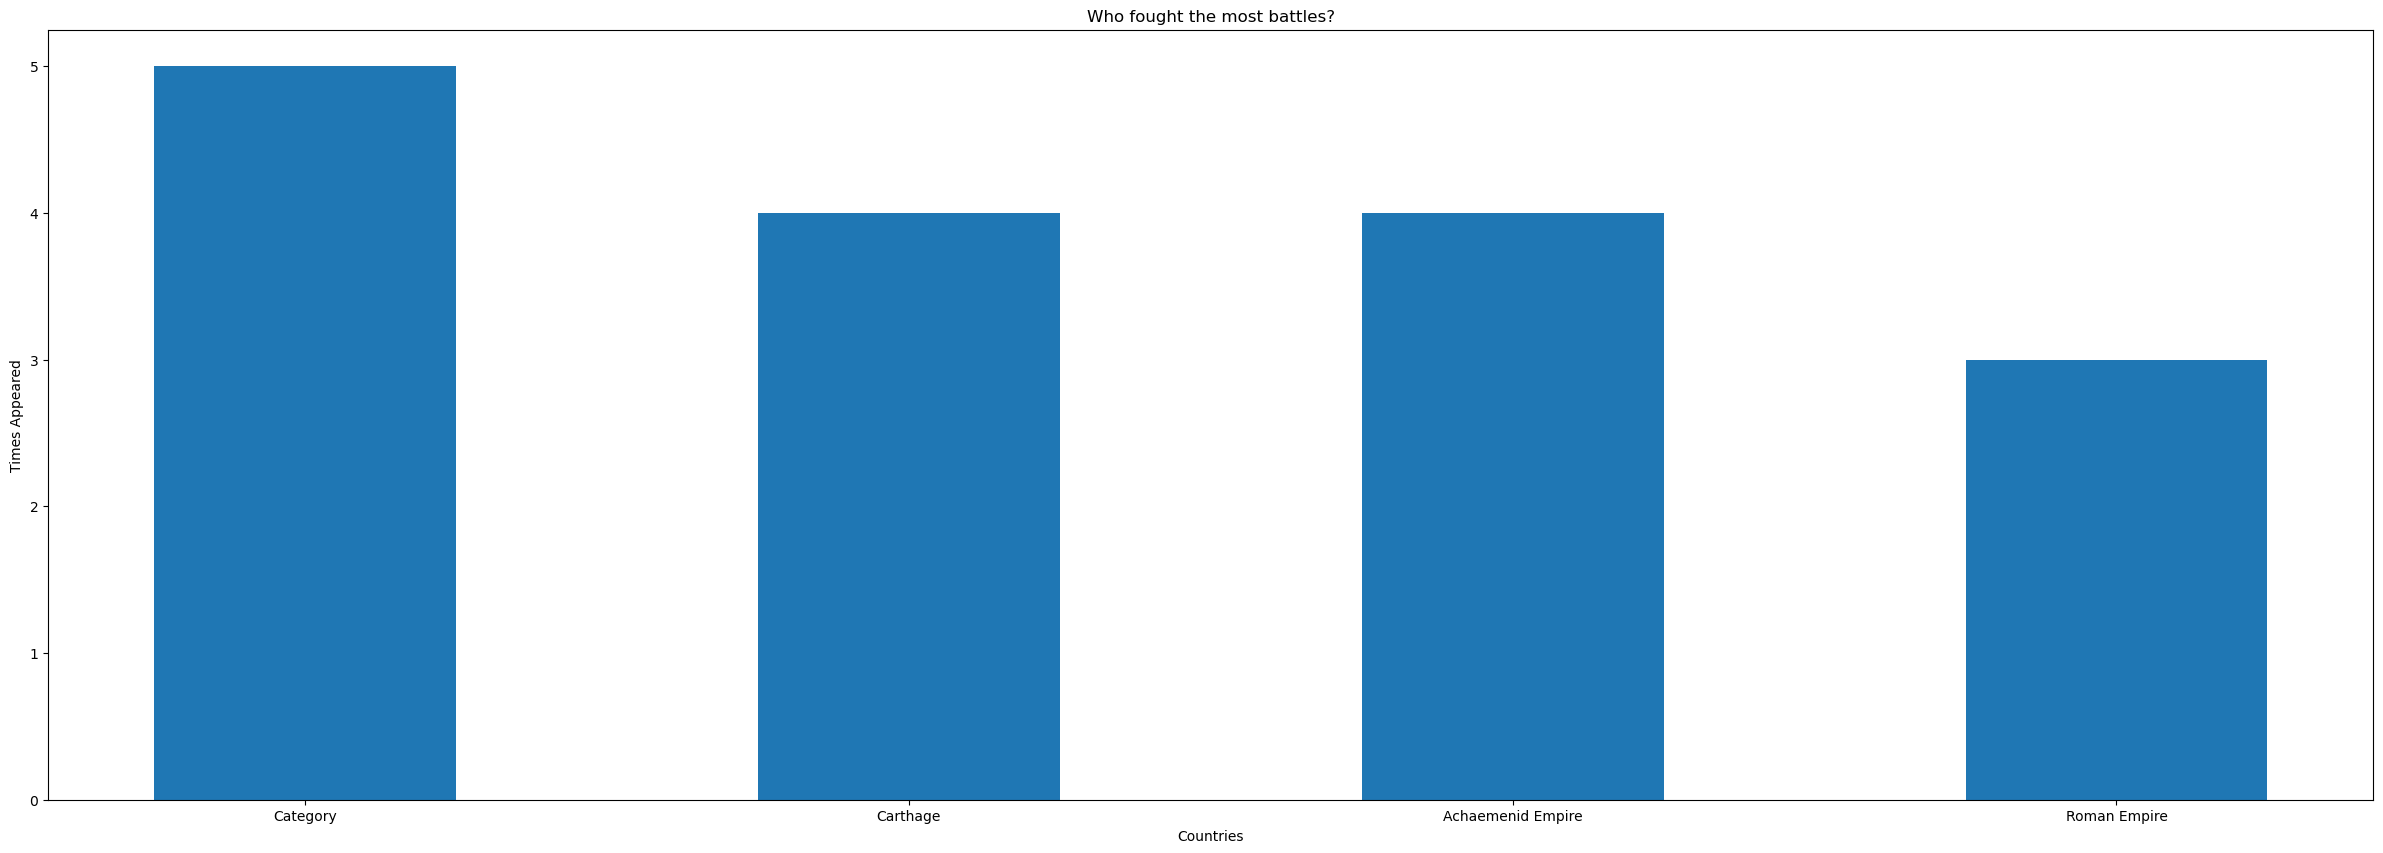

<module 'matplotlib.pyplot' from '/Users/wyt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [20]:
count_belligerents(ancient_battles)

Note: if you run the code on 2000 battles, the results of ancient battles mighe be inaccurate due to a small sample size and an inperfection in the data-finding algorithm.

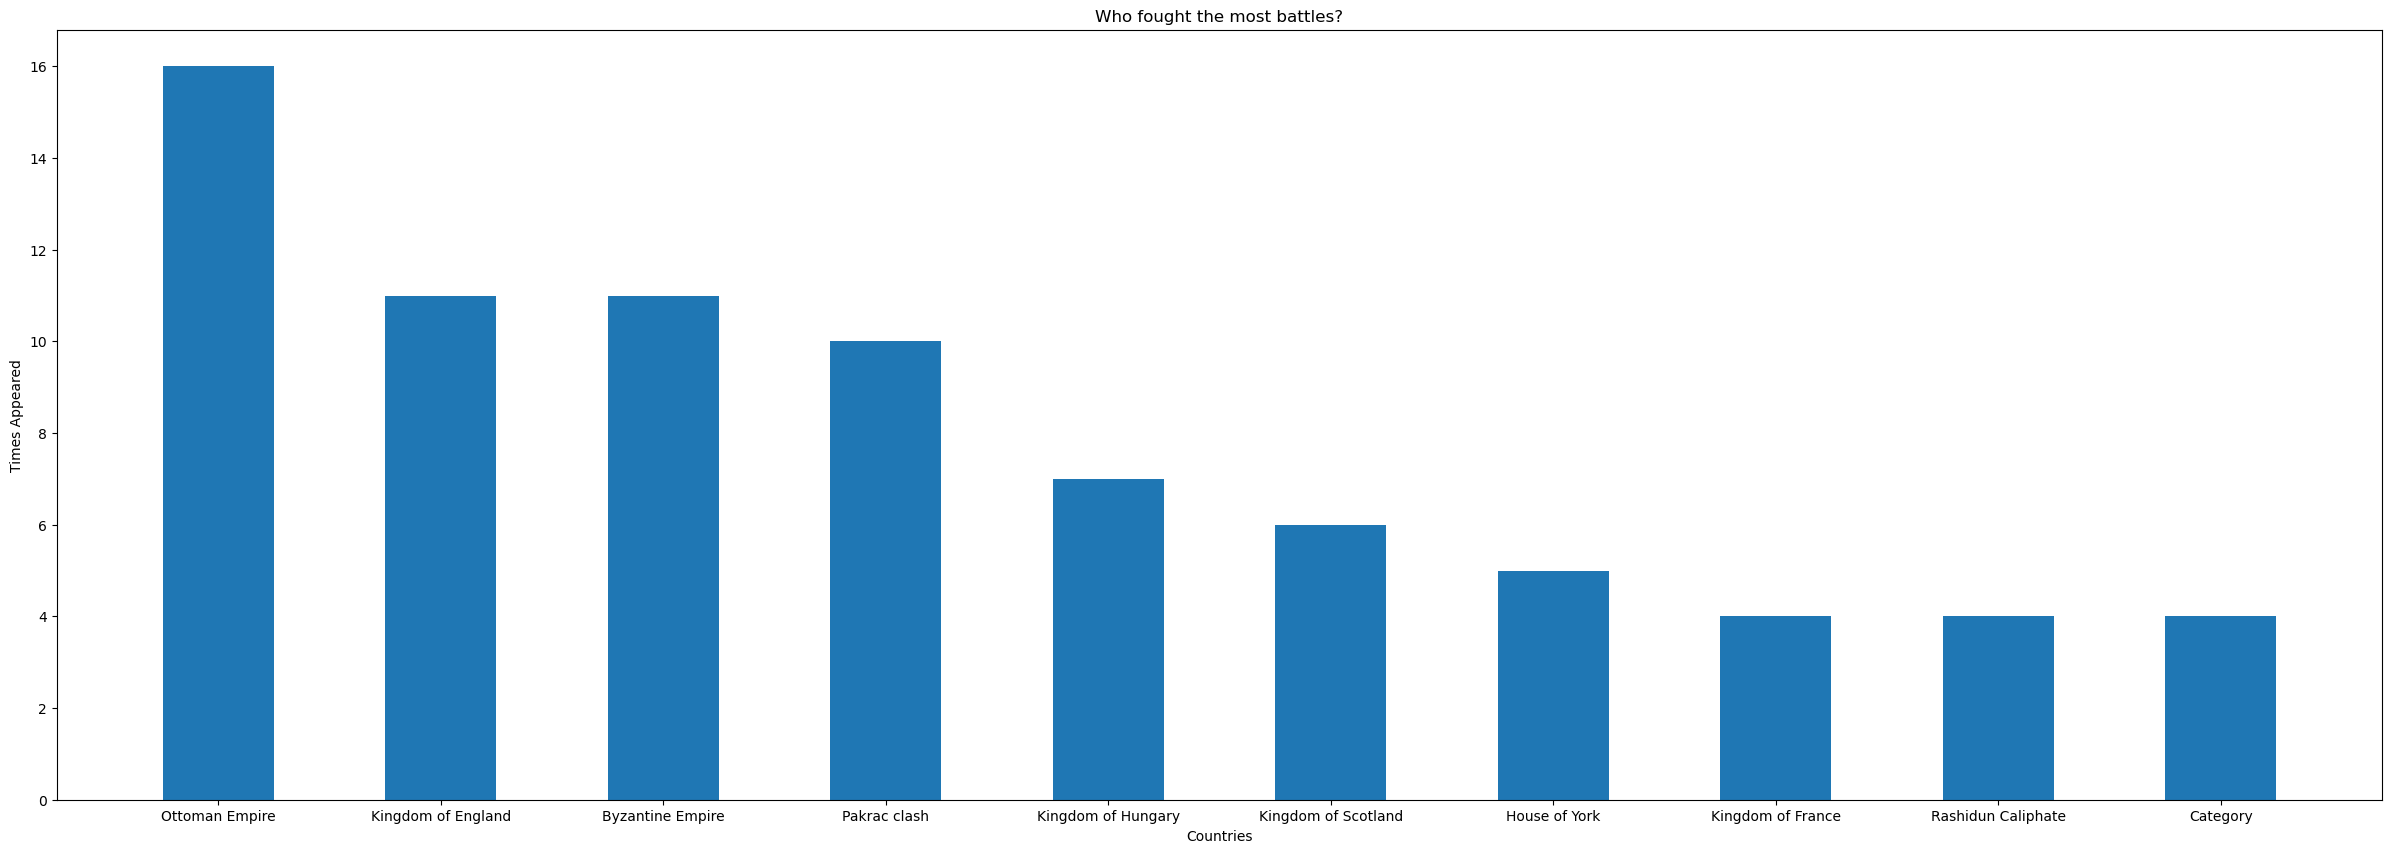

<module 'matplotlib.pyplot' from '/Users/wyt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [21]:
count_belligerents(post_classical_battles)

#### Modern History

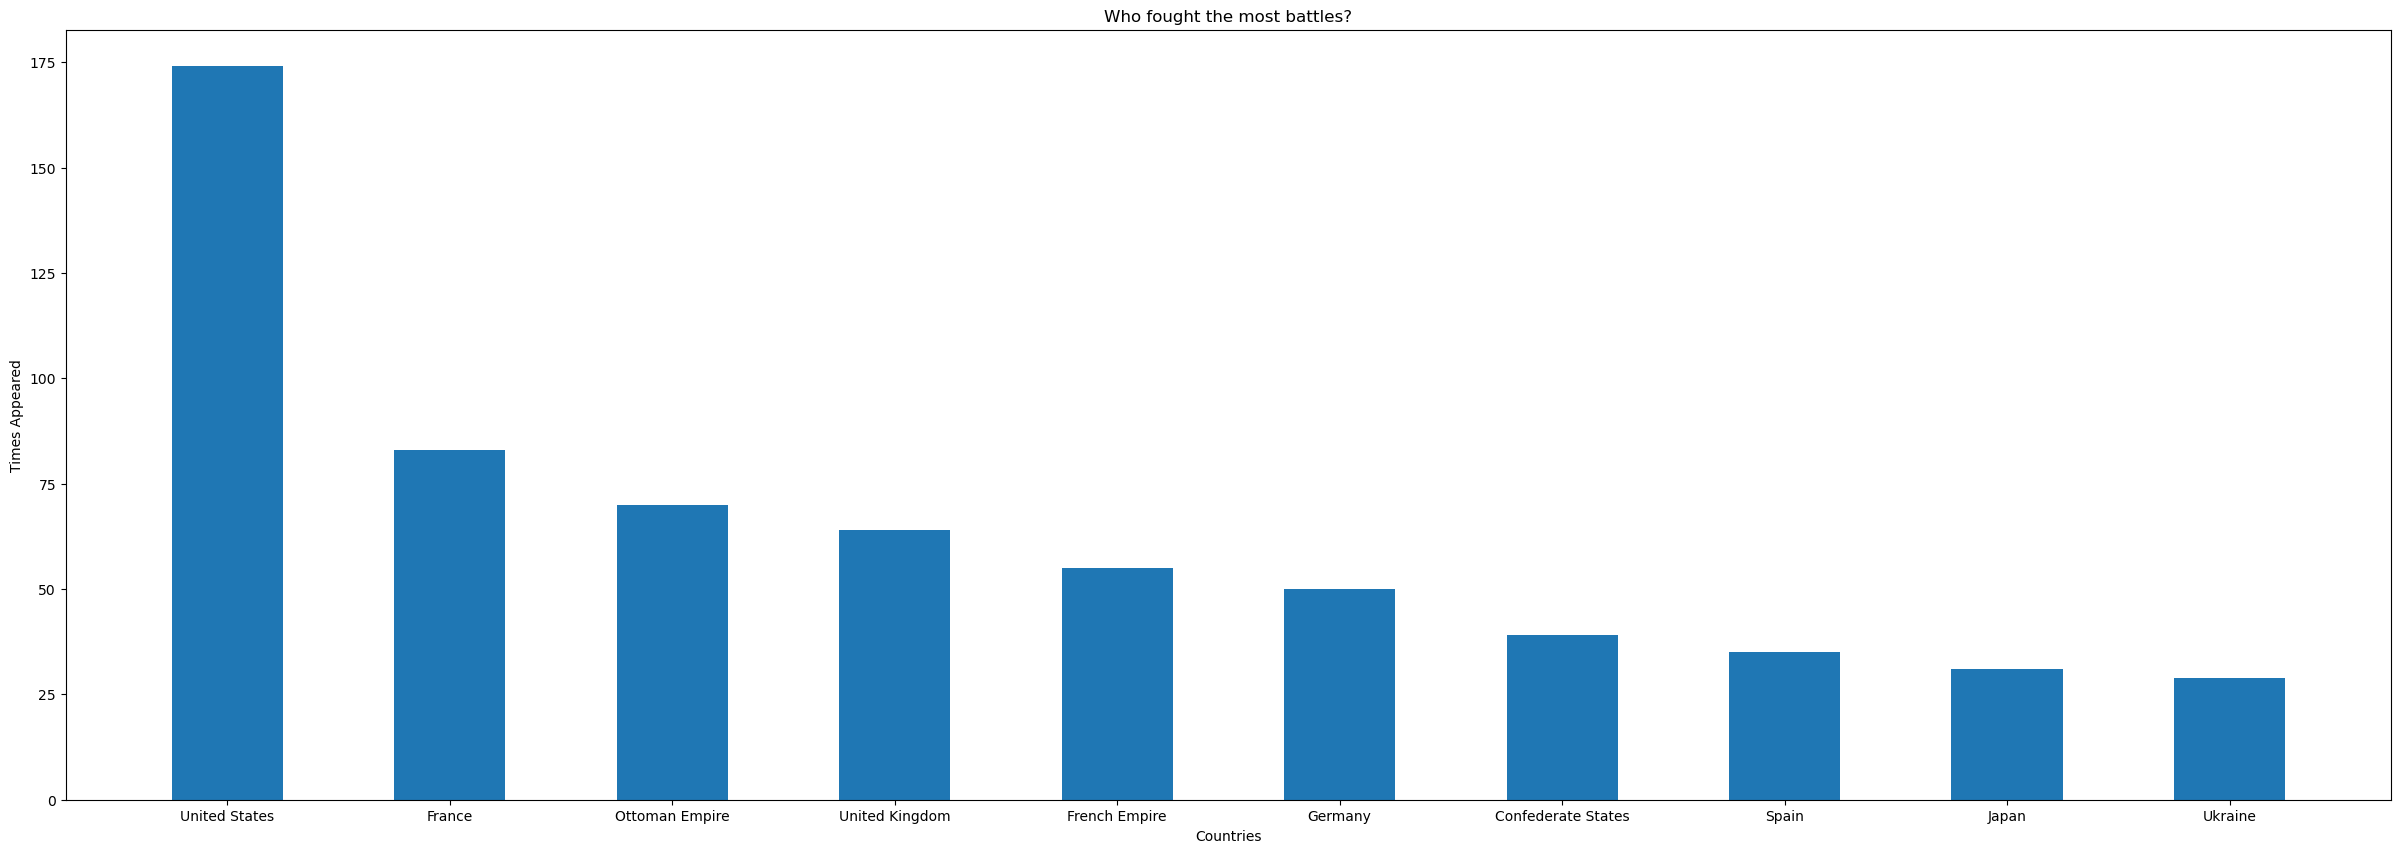

<module 'matplotlib.pyplot' from '/Users/wyt/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [22]:
count_belligerents(modern_battles)

#### Conclusion

Most ancient battles recorded on Wikipedia were fought by Rome, Carthage, and Greek States. That's easily predictable, as Roman battles were the most famous ones.

Byzantine, Kingdom of England, Rashidun Caliphate and Ottoman Empire fought the most battles during post-classical era. Two of them are Christian, and two are Muslim. So this result reflects the importance of the Crusades in post-classical history.

Modern battles are fought mostly by the United States. Japan came very behind on this list, so it indicates that the United States fought a wide range of enemies in addition to fighting Japan.

## Question 6: Which battles are included both in Wikipedia and Wikibooks?

The link to the search results for 'Battle of' in Wikibooks:
https://en.wikibooks.org/w/index.php?search=battle+of+battle+of+intitle%3A%22battle+of%22&title=Special%3ASearch&profile=advanced&fulltext=1&advancedSearch-current=%7B%22fields%22%3A%7B%22phrase%22%3A%22battle+of%22%2C%22intitle%22%3A%22battle+of%22%7D%7D&ns0=1&ns4=1&ns102=1&ns110=1&ns112=1

In [23]:
my_url = 'https://en.wikibooks.org/w/index.php?search=battle+of+battle+of+intitle%3A%22battle+of%22&title=Special%3ASearch&profile=advanced&fulltext=1&advancedSearch-current=%7B%22fields%22%3A%7B%22phrase%22%3A%22battle+of%22%2C%22intitle%22%3A%22battle+of%22%7D%7D&ns0=1&ns4=1&ns102=1&ns110=1&ns112=1'
headers = {'User-Agent': 'Webscraping practice  (tomwuyutao@gmail.com)'}
response = requests.get(my_url, headers=headers)
sel = Selector(text=response.text)

Getting the links of the wikibooks page for each book:

In [24]:
book_links = sel.xpath('//div[1]/a/@href').getall()
book_links.pop(0)
book_links.pop(-1)

'/wiki/Main_Page'

Correcting the links:

In [25]:
list_of_book_links = ['https://en.wikibooks.org' + x for x in book_links]

Extracting the titles

In [26]:
list_of_titles = []
for item in list_of_book_links:
    my_url = item
    response = requests.get(my_url, headers=headers)
    sel = Selector(text=response.text)
    title_of_book = sel.xpath('//h1/span/text()').getall()[0]
    list_of_titles.append(title_of_book)

Putting the extracting algorithm into a loop:

In [27]:
battles_in_wikibooks = []

for item in list_of_titles:
    
    # I want to only keep the words starting from "Battle of" in each battle. 
    # So I split them first, then identify where is the word 'Battle', and starts appending the words.
    item = item.replace('/',' ')
    item = item.split()
    extract_this_word = False
    temp_list = []
    for word in item:
        if word == 'Battle':
            extract_this_word = True
        if extract_this_word == True:
            temp_list.append(word)
    extract_this_word = False
    
    corrected_title = ''
    
    for item in temp_list:
        corrected_title += ' '
        corrected_title += item

    corrected_title = corrected_title.strip()

    if corrected_title != '':
        battles_in_wikibooks.append(corrected_title)

In [28]:
battles_in_wikipedia = [x[0] for x in updated_list]
battles_in_both = [x for x in battles_in_wikibooks if x in battles_in_wikipedia]

In [29]:
print(battles_in_both)

['Battle of Britain', 'Battle of Cannae', 'Battle of the Atlantic', 'Battle of France', 'Battle of Khe Sanh', 'Battle of Badr', 'Battle of Uhud', 'Battle of Khaybar', 'Battle of the Trench']
